In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal, Categorical
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.nn.utils.clip_grad import clip_grad_value_, clip_grad_norm_

import string
from random import *
import re
import math
import time

import subprocess, os, glob
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as st

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

print (os.getcwd())

print(torch.__version__)

from multimodal import MultiModalClassification
from GMM import *

cuda
/home/tbjackso/MemStateEvolution
1.0.0


In [109]:
class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()
        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))
        
        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))
        
    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1
        
        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)
        
        return m_hat / (torch.sqrt(v_hat) + self.eps)


class RBN(nn.Module):
    def __init__(self, inputs, gaussians, lr=0.0001, min_sig=0.01,
                 log=False, stable=True, MLP=True):
        super(RBN, self).__init__()
        self.inputs = inputs
        self.gaussians = gaussians
        
        self.Pis = nn.Parameter(torch.randn((1, gaussians)))
        self.Sigs = nn.Parameter(torch.randn((1, gaussians, inputs)))
        self.Mus = nn.Parameter(torch.randn((1, gaussians, inputs)))
    
        self.Pi_adam = Adam(self.Pis)
        self.Sig_adam = Adam(self.Sigs)
        self.Mu_adam = Adam(self.Mus)
        
        self.lr = lr
        self.min_sig = torch.log(torch.tensor(min_sig))
        
        self.log = log
        self.stable = stable
        self.MLP = MLP
    
    def params(self):  
        Pis = F.softmax(self.Pis, dim=1)
        Sigs = self.Sigs.exp()
        Mus =  self.Mus
        
        return (Pis, Sigs, Mus)
    
    def forward(self, x, lr=None):
        # This returns both the p vector to higher levels and the dP/dx for feed back
        # If in training mode it will also perform update of this layer's parameters
        
        (pi, sig, mu) = self.params()
        
        xt = torch.zeros_like(x, requires_grad=True)
        xt.data = x
        x = xt
        
        # Do parameter learning
        if (self.training):
            self.learn(x, lr)
        
        if (self.MLP):
            p = MixtureLogProb(x, pi, sig, mu)
        else:
            p = GMMProbs(x, pi, sig, mu, stable=self.stable, log=self.log)
        
        # Calculate backwards vector
        loss = GMMLoss(x, pi, sig, mu)
        loss.backward()
        dpdx = x.grad
        
        return (p.detach(), dpdx.detach())
    
    def learn(self, x, lr=None):
        
        (pi, sig, mu) = self.params()
        
        if (lr is None):
            lr = self.lr
            
        self.Pis.grad = torch.zeros_like(self.Pis)
        self.Sigs.grad = torch.zeros_like(self.Sigs)
        self.Mus.grad = torch.zeros_like(self.Mus) 
            
        loss = GMMLoss(x, pi, sig, mu)
        loss.backward()
        
        self.Pis.data  -= lr*self.Pi_adam(self.Pis.grad)
        self.Sigs.data -= lr*self.Sig_adam(self.Sigs.grad)#.clamp(0.01)
        self.Mus.data  -= lr*self.Mu_adam(self.Mus.grad)
        
        # Range bounding
        self.Sigs.data = torch.clamp(self.Sigs, min=self.min_sig)
        
D = 5
G = 10
BS = 20

x = torch.zeros(20,5)

# net = DeepDNN(D, 2*D, G).e?val()
net = RBN(5, 10).eval()
(pi, sig, mu) = net.params()
print (pi.shape, sig.shape, mu.shape)

(p, dx) = net(x)
print (p.shape)
print (dx.shape)


torch.Size([1, 10]) torch.Size([1, 10, 5]) torch.Size([1, 10, 5])
torch.Size([20, 10, 5])
torch.Size([20, 10])
torch.Size([20, 10])
torch.Size([20, 10])
torch.Size([20, 5])


In [8]:
class DeepDNN(nn.Module):
    def __init__(self, I, L1, O, lr=1e-3):
        super(DeepDNN, self).__init__()
        
        self.L1 = RBN(I, L1, lr=lr, log=True)
        self.L2 = RBN(L1, O, lr=lr, log=True)
        
    def forward(self, x):
        
        (x1, _) = self.L1(x)
        (x2, dx1) = self.L2(x1)
        
        return (x2, dx1)
    
    def learn(self, x):
        (x1, _) = self.L1(x)
        
        self.L1.learn(x)
        self.L2.learn(x1)
        

In [9]:
D = 5
G = 10
BS = 20

x = torch.zeros(BS,D)

net = DeepDNN(D, 2*D, G).eval()
# net = DNN(D, G).eval()
# (pi, sig, mu) = net.params()


(p, dx) = net(x)
print (p.shape)
print (dx.shape)


torch.Size([20, 10])
torch.Size([20, 10])


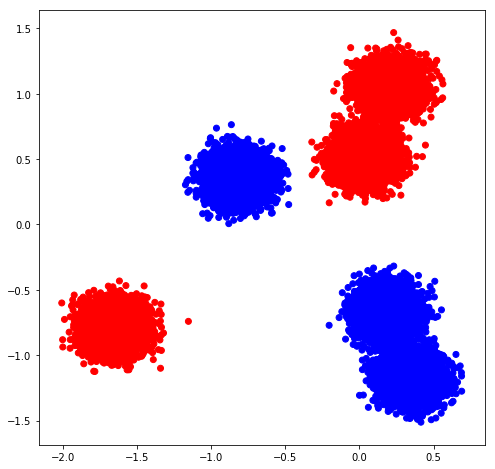

In [63]:
C = 2
M = 3
D = 2

batch_size = 100
dataset = DataLoader(MultiModalClassification(C, M, D, noise=0.1, samples=5000),
                     batch_size=batch_size, shuffle=True)

plotSet(dataset)

In [68]:
G = 3
lr = 0.0005
net = DNN(D, G, lr).eval()
# net = DeepDNN(D, G, G, lr=lr).eval()

s = time.time()
epochs = 100

for e in range(epochs):
    loss = 0
    for (data, label) in dataset:
        (p, _) = net(data)
        (pi, sig, mu) = net.params()
        
#         loss += GMMLoss(data, pi, sig, mu)
        print (GMMLoss(data, pi, sig, mu))
        print (p.sum(1).mean())
#         loss += p.sum(1).mean()
        net.learn(data)
            
        raise ValueError("STOP")

    print ("Epoch {} : {}".format(e, loss))
e = time.time()
print (e-s)

tensor(3.3297, grad_fn=<NegBackward>)
tensor(1.2485)


ValueError: STOP

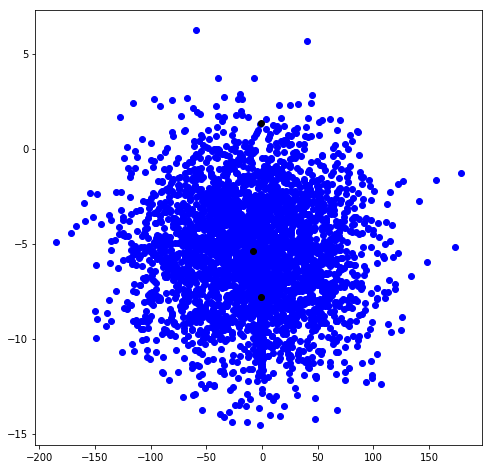

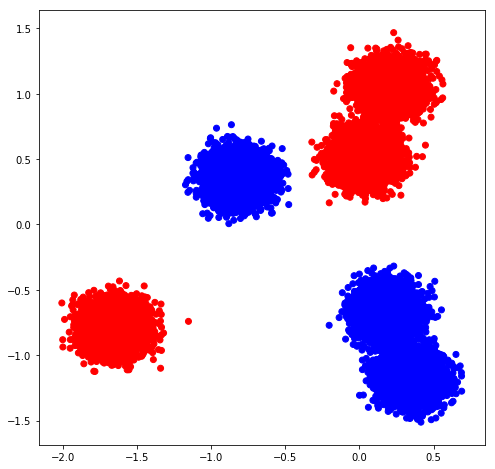

tensor([[6.8249e-01, 3.1750e-01, 5.2742e-06]], grad_fn=<SoftmaxBackward>)
tensor([[[51.3009,  2.9775, 51.6862],
         [ 0.5576,  1.4695,  8.6377],
         [ 1.4134,  0.4541,  0.9080]]], grad_fn=<ExpBackward>)
Parameter containing:
tensor([[[ -8.3645,  -5.3910, -11.9592],
         [ -0.5687,  -7.8272, -14.5714],
         [ -0.5126,   1.3589,   0.5207]]], requires_grad=True)


In [66]:
(pi, sig, mu) = net.L2.params()

plotGMM(pi, sig, mu, show=False)
plotSet(dataset)

print (pi)
print (sig)
print (mu)

In [51]:
net.log = True

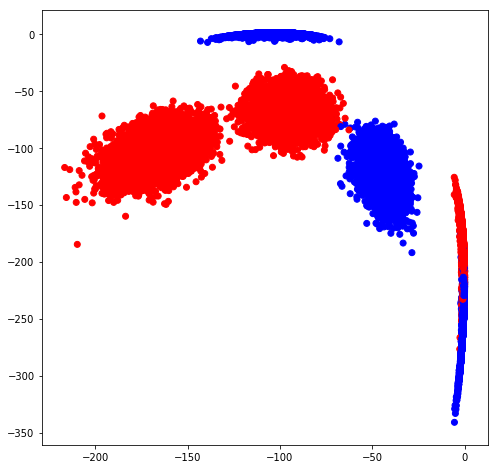

In [55]:

# net = DNN(D, G, lr).eval()

layer2 = []
for (data, label) in dataset:
    (p, _) = net(data)
#     print (p)
#     raise ValueError("Stop")
    layer2.append((p, label))
    

plotSet(layer2,[0,1])

# MNIST
Enough playing around with artificial datasets... Lets try MNIST. We might have a problem with size. If so we can side step with autoencoder trick for now but eventually should do CNN-DNN

In [122]:
BS = 100
G = 30
D = 784
lr = 0.0005

device = 'cuda:1'

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

# Training dataset
big_batch = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=500, shuffle=True, pin_memory=False)

In [5]:

net = DNN(D, G, lr).eval()
net.to(device)


s = time.time()
epochs = 1500

for e in range(epochs):
    loss = 0
    for (data, label) in train_loader:
        data = data.view(-1,784).to(device)
#         print (data.shape)
        (p, _) = net(data)
        (pi, sig, mu) = net.params()
        
        loss += GMMLoss(data, pi, sig, mu).item()
        net.learn(data)
            
#         raise ValueError("STOP")

    print ("Epoch {} : {}".format(e, loss))
e = time.time()
print (e-s)

RuntimeError: The size of tensor a (784) must match the size of tensor b (5) at non-singleton dimension 2

1.6639049053192139 0.011212495155632496 70.81317138671875
torch.Size([1, 30])
tensor([0.1268, 0.1255, 0.0825, 0.0771, 0.0697, 0.0464, 0.0411, 0.0373, 0.0357,
        0.0357, 0.0345, 0.0332, 0.0324, 0.0292, 0.0287, 0.0270, 0.0183, 0.0166,
        0.0149, 0.0131], device='cuda:1', grad_fn=<SliceBackward>)
tensor([28, 15,  4, 11, 10, 13, 20, 17, 23, 19,  0, 16,  8, 27,  1, 29,  9, 18,
         3,  6], device='cuda:1')
torch.Size([1, 30, 784])
torch.Size([784])


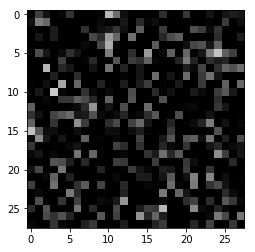

--------
torch.Size([100, 30])
tensor([-2547.6289, -2642.1025, -2752.2129, -2775.1943, -2781.6440, -2857.7603,
        -3029.2417, -3063.1465, -3077.9521, -3180.4021], device='cuda:1')
tensor([19, 22, 23,  5, 18, 21,  4, 20, 28,  9], device='cuda:1')


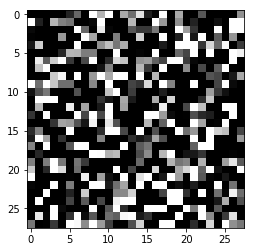

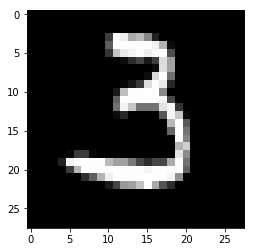

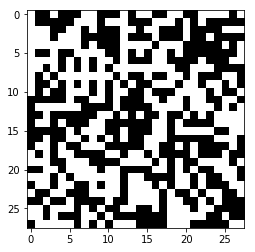

--------


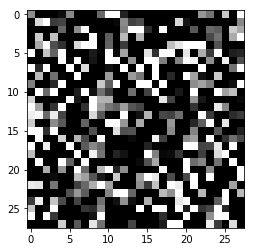

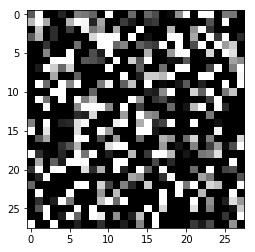

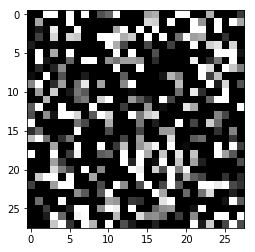

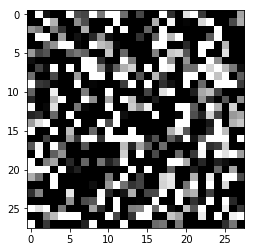

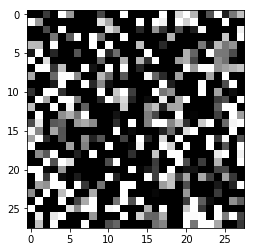

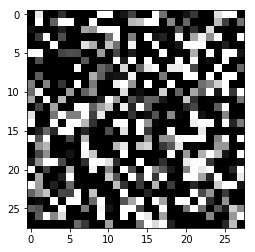

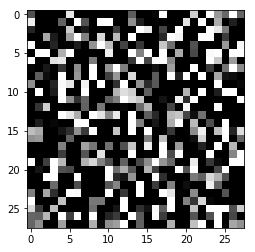

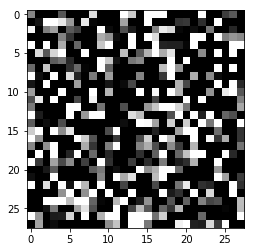

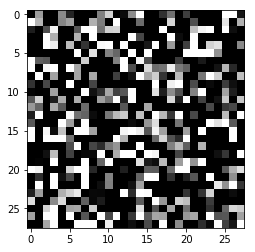

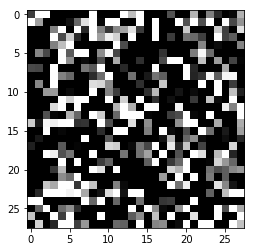

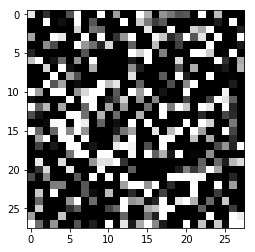

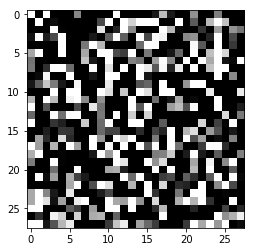

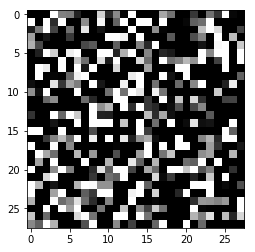

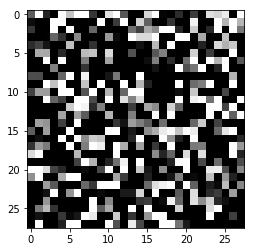

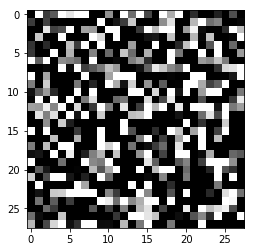

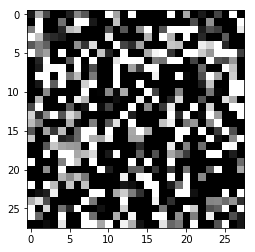

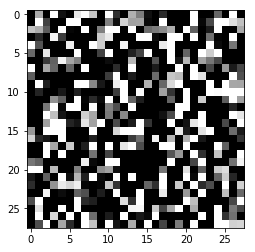

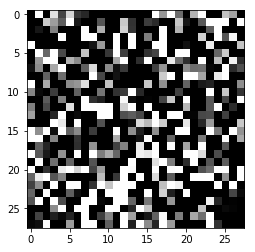

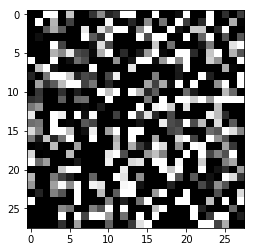

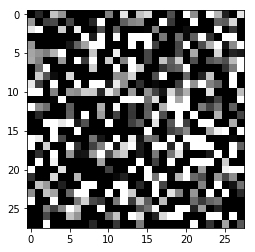

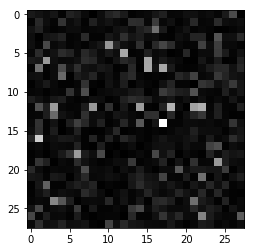

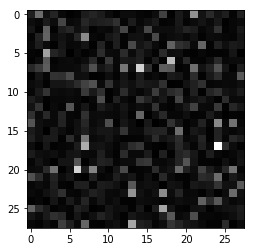

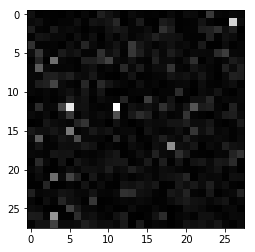

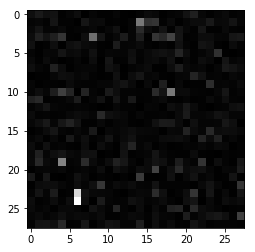

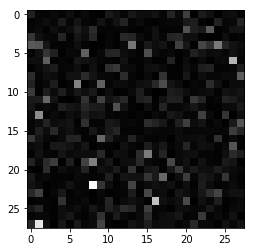

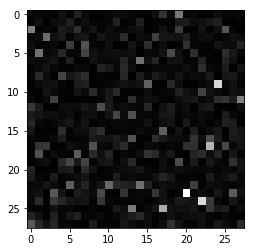

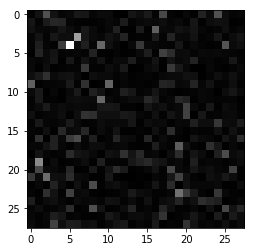

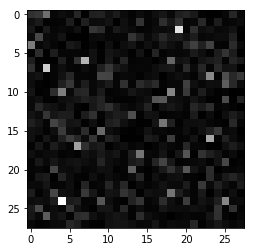

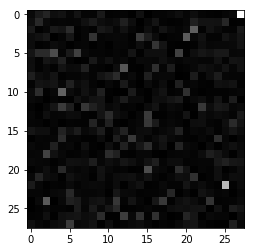

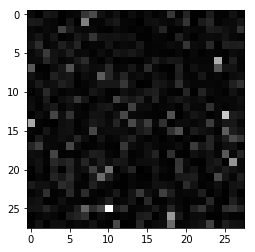

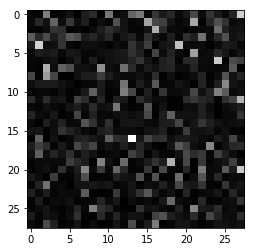

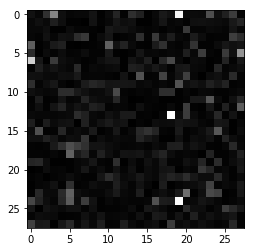

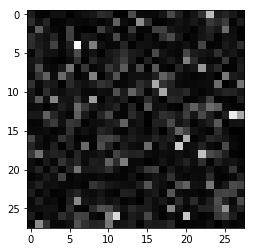

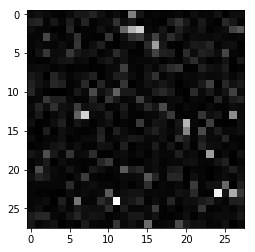

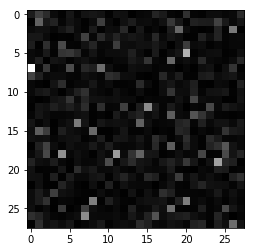

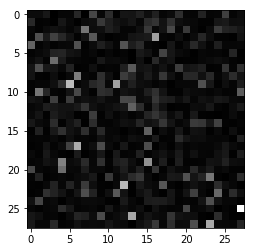

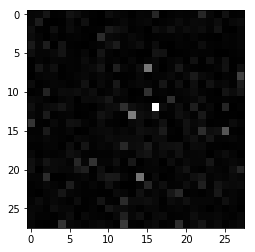

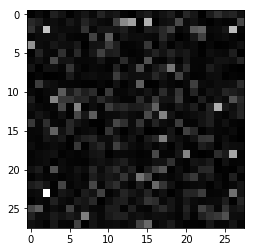

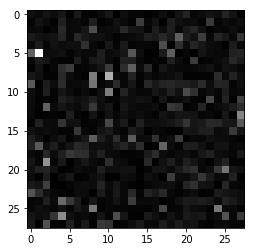

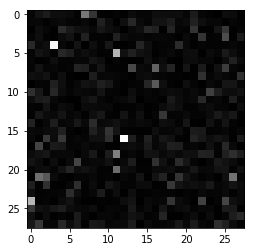

In [8]:
(pi, sig, mu) = net.params()

print (sig.mean().item(), sig.min().item(), sig.max().item())

(val,ind) = pi.sort(descending=True)
print (pi.shape)
print (val[0,:20])
print (ind[0,:20])

print (mu.shape)
t = mu[0,ind[0,0],:]
print (t.shape)
tt = (pi.unsqueeze(-1) * mu).sum(1).squeeze()

plt.imshow(tt.view(28,28).detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()
print ("--------")

# (data, label) = next(iter(train_loader))
data = data.to(device)
(p,dx) = net(data.view(-1, 784))
print (p.shape)
(vp,tp) = p[1].sort(descending=True)
print (vp[:10])
print (tp[:10])
ttt = (p[0].unsqueeze(-1) * mu).sum(1).squeeze()

plt.imshow(mu[0,tp[1],:].view(28,28).cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()

plt.imshow(data[0].view(28,28).detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(ttt.view(28,28).detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()
print ("--------")

for i in range(20):
    plt.imshow(mu[0,ind[0,i],:].view(28,28).cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
    plt.show()
    
for i in range(20):
    plt.imshow(sig[0,ind[0,i],:].view(28,28).cpu().detach().numpy(), cmap='gray')
    plt.show()

In [126]:
torch.save(net.state_dict(), 'part3.trch')

In [17]:
net.load_state_dict(torch.load('part3.trch'))

In [7]:
net = DNN(D, G, log=True, stable=False).to(device).eval()

In [21]:
net.log=True
net.stable=True

In [41]:
labelcount = torch.zeros(G,10, dtype=torch.long)
nonzeros = torch.zeros(G, dtype=torch.long)
dominance = torch.zeros(G)

maxv = 0
meanv = 0
for (data, label) in test_loader:
    data = data.to(device)
    (p, _) = net(data.view(-1, 784))
    (vmx, idx) = torch.max(p, dim=1)
#     print (p[0])
    nz = (p>0).sum(1)
    d = p*(p>0).float()
    tm = p.max().item()
    meanv += p.mean().item()/nz.sum().item()
    if tm > maxv:
        maxv = tm
    d = d/(d.sum(1, keepdim=True)+1e-8)
    
#     print (d[0])
#     raise ValueError('STOP')
    
    for i in range(label.shape[0]):
        labelcount[idx[i], label[i]] += 1
        nonzeros[nz[i]] += 1
        for j in range(G):
            dominance[j] += d[i,j]/label.shape[0]
        
meanv /= len(test_loader)
print (maxv, meanv)
print (labelcount)
print (nonzeros)
print (dominance/len(test_loader))

2274.70947265625 -29.464006113892374
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0],
        [ 13,   2, 389, 136,   8,  39,  51,   0,  15,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  5,   1,  24, 102,  43,  13,   0,  11,   7,  19],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 86, 156,  15,  24,  74,  51, 213,   4, 118,   9],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 841,   0,   0,   0,   0,   1,   0,   2,   2],
        [  1,   0,   3,  26,  55,  14,   0, 376,  19, 177],
        [ 20,   1,  52,  12,  21,  16,  52,  38,  14,  15],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
   

In [37]:
(pi, sig, mu) = net.params()
print (pi.min().item(), pi.mean().item(), pi.max().item())
lp = pi.log()
print (lp.min().item(), lp.mean().item(), lp.max().item())
print (math.e)

3.82643361440671e-11 0.03333333507180214 0.11453649401664734
-23.98650360107422 -14.09716510772705 -2.1668617725372314
2.718281828459045


why are these SO different... Time to look into if the gmmloss and prob funcitons are correct. Is it because of dimension? are we really doing log sum or is it secretly sum log?

# Convolutional RBN
Because its probably easier to learn smaller filters

In [110]:
class CRBN(nn.Module):
    def __init__(self, in_size, out_channels, kernel_size, stride=1, lr=1e-3, log=False, MLP=True):
        super(CRBN, self).__init__()
        
        (k0, k1) = kernel_size
        (c,h,w) = in_size
        
        # D1 = product of kernel dims and input channels
        D = c * k0 * k1
        hp = (h-k0)//stride+1
        wp = (w-k1)//stride+1
        L = hp*wp
        
        self.L = L
        self.D = D
        self.C = c
        self.K = kernel_size
        self.G = out_channels
        
        self.unfold = nn.Unfold(kernel_size, stride=stride)
        self.fold_forward  = nn.Fold((hp,wp), (1,1), stride=1)
        self.fold_backward = nn.Fold((h,w), kernel_size, stride=stride)
        self.RBN = RBN(D, out_channels, lr=lr, log=log, MLP=MLP)
        temp = torch.zeros((1,D,L))
        self.normalizer = nn.Parameter(self.fold_backward(temp), requires_grad=False)
        
    def forward(self, x):
        
        # This is basically identical to the DNN layer but with transforming the image
        # first then applying the learning to every window
        # In order to do this I need to know how big the L vector will be
        # then create an DNN forthat size
        # to learn/feed forward I need to reshape image then pass it down
        # then I need to take the result and reshape back
        (bs,c,h,w) = x.shape
#         print ("===============")
#         print ('x  ', x.shape)
        x1 = self.unfold(x).transpose(1,2).contiguous().view(-1, self.D)
#         print ('x1 ', x1.shape)
        (yuf, dx1) = self.RBN(x1)
#         print ('yuf', yuf.shape)
#         print ('dx1', dx1.shape)
        y = self.fold_forward(yuf.view(bs,self.L,self.G).transpose(1,2))
#         print ('y  ',y.shape)
        dx = self.fold_backward(dx1.view(bs,self.L,self.D).transpose(1,2))/self.normalizer
#         print ('dx ', dx.shape)
#         print ("--------------")
        return (y, dx)
    
    def learn(self, x):
        x1 = self.unfold(x).view(-1, self.D)
        self.RBN.learn(x1)
        
    def params(self, reshape=False):
        (pi, sig, mu) =  self.RBN.params()
        mss = sig.shape
        if (reshape):
            mss = (self.G, self.C)+self.K
        return (pi, sig.view(mss), mu.view(mss))
        

x = torch.zeros(100,1,28,28)

tnet = CRBN((1,28,28), 10, (5,5)).eval()

(pi,sig,mu) = tnet.params()
print (mu.shape)

(p, dx) = tnet(x)
print (p.shape)
print (dx.shape)

torch.Size([1, 10, 25])
torch.Size([57600, 10, 25])
torch.Size([57600, 10])
torch.Size([57600, 10])
torch.Size([100, 10, 24, 24])
torch.Size([100, 1, 28, 28])


In [300]:
lr = 5e-3
net = CRBN((1,28,28), 30, (5,5), log=False, lr=lr).eval()
net.to(device)

s = time.time()
epochs = 20

for e in range(epochs):
    loss = 0
    for (data, label) in train_loader:
        data = data.to(device)
#         print (data.shape)
        with silence():
            (p, _) = net(data)
        (pi, sig, mu) = net.params()
        dt = net.unfold(data).view(-1, net.D)
#         print (dt.shape)
#         print (net.D)
        loss += GMMLoss(dt, pi, sig, mu).item()
        net.learn(data)
            
#         raise ValueError("STOP")

    print ("Epoch {} : {:.3f}".format(e, loss))
e = time.time()
print (e-s)

Epoch 0 : -1118.848
Epoch 1 : -18306.024
Epoch 2 : -21126.245
Epoch 3 : -22836.090
Epoch 4 : -23268.915
Epoch 5 : -23443.539
Epoch 6 : -23548.073
Epoch 7 : -23601.486
Epoch 8 : -23654.528
Epoch 9 : -23698.677
Epoch 10 : -23746.452
Epoch 11 : -23746.720
Epoch 12 : -23746.700
Epoch 13 : -23746.898
Epoch 14 : -23746.939
Epoch 15 : -23747.131
Epoch 16 : -23747.162
Epoch 17 : -23746.946
Epoch 18 : -23746.994
Epoch 19 : -23747.054
673.9551589488983


In [229]:
a = torch.arange(25)
b = a.view((5,5))
print (b)

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])


torch.Size([30]) torch.Size([30, 1, 5, 5]) torch.Size([30, 1, 5, 5])
torch.Size([30])
tensor([1.8956e-01, 1.3296e-01, 1.1803e-01, 8.8011e-02, 8.6164e-02, 8.3148e-02,
        8.2133e-02, 7.9994e-02, 7.2204e-02, 5.3941e-02, 1.3767e-02, 1.7535e-05,
        1.0635e-05, 1.0570e-05, 7.1372e-06, 7.1134e-06, 5.7634e-06, 4.2422e-06,
        3.2702e-06, 2.3620e-06])
tensor([ 2, 18,  5, 26,  1,  9, 15, 20,  6, 19, 13, 27,  0,  8, 25, 17, 29,  4,
         3, 24])
torch.Size([20, 1, 5, 5])
torch.Size([5, 5])


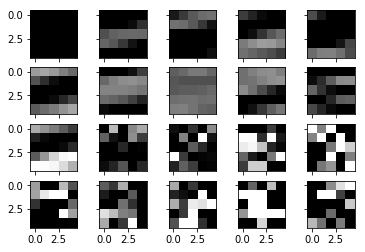

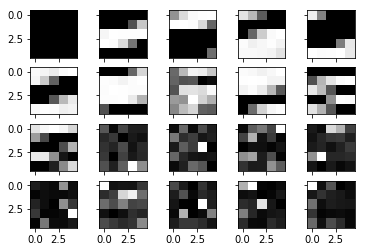

In [301]:
(pi, sig, mu) = [x.cpu().detach() for x in net.params(True)]
pi = pi.squeeze()
print(pi.shape, sig.shape, mu.shape)
# print (pi.sort(descending=True))
vp,pp = pi.sort(descending=True)
print (pp.shape)
print (vp[:20])
print (pp[:20])

print (mu[pp[:20]].shape)
emu = mu[pp[:20]]
print (mu[16,0].shape)
# print (mu[16].view(1,5,5))

fig, ax = plt.subplots(4,5, sharex=True, sharey=True)
for i in range(20):
    px = i//5
    py = i%5
    ax[px,py].imshow(emu[i,0], cmap='gray', vmin=0, vmax=1)
plt.show()

fig, ax = plt.subplots(4,5, sharex=True, sharey=True)
for i in range(20):
    px = i//5
    py = i%5
    ax[px,py].imshow(sig[pp[i],0], cmap='gray')
plt.show()

torch.Size([100, 1, 28, 28])
torch.Size([100, 30, 24, 24])
------------
torch.Size([57600, 25])
torch.Size([57600, 30])
torch.Size([57600, 25])


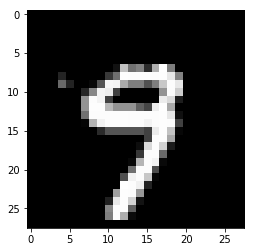

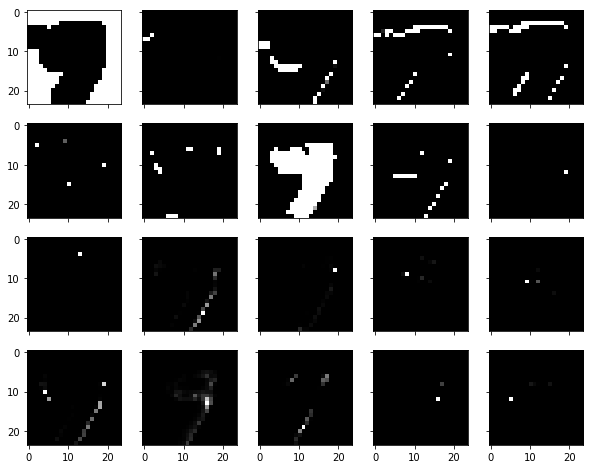

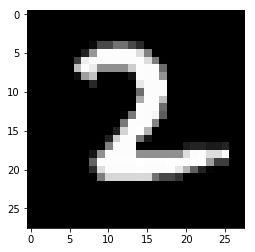

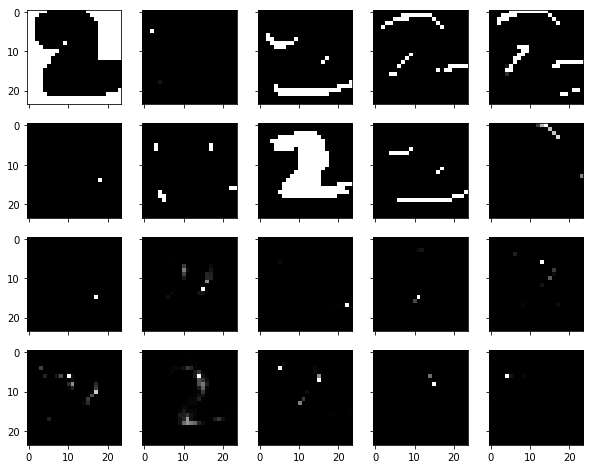

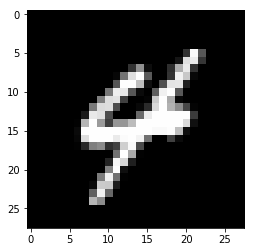

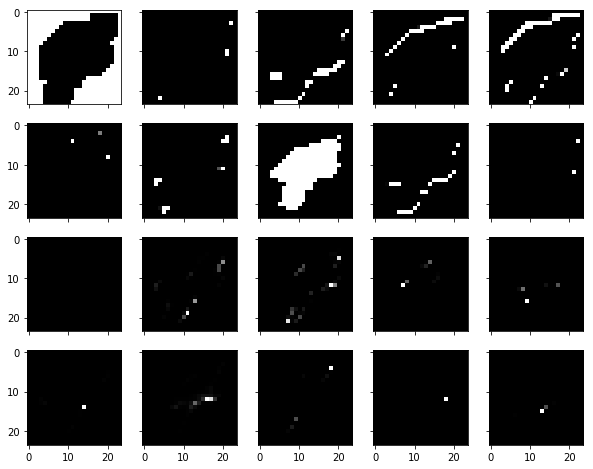

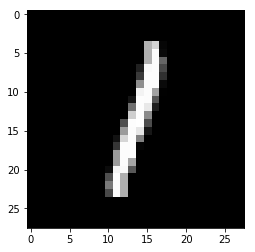

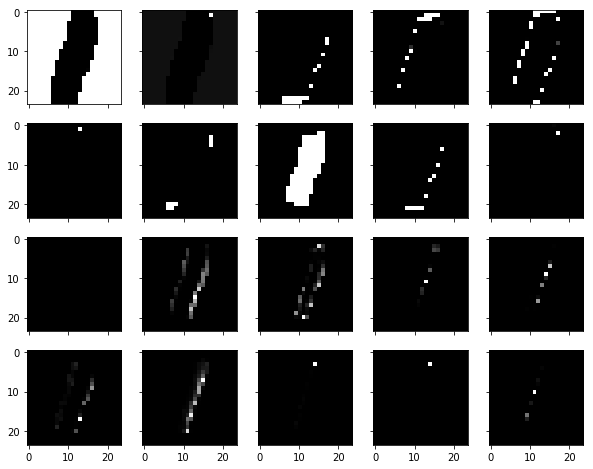

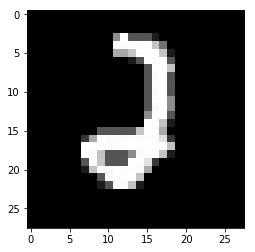

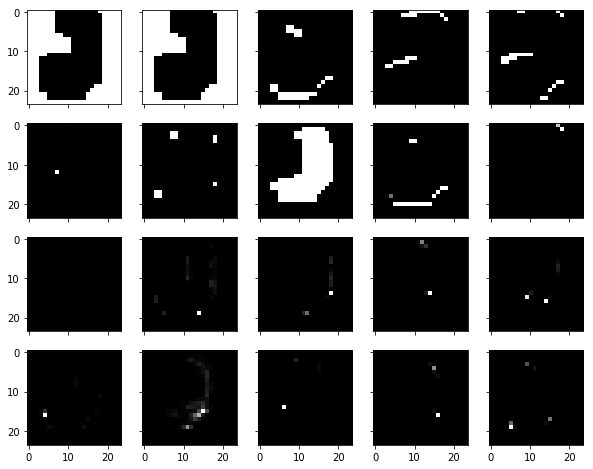

In [302]:
print (data.shape)
net.RBN.log=False
(y, _) = net(data)
print (y.shape)
y = y.cpu().detach()
# y = y.clamp(min=0)
# print (y[0,0].flatten())

print ("------------")
(bs,c,h,w) = data.shape
xt = net.unfold(data).view(-1,net.D)
print (xt.shape)
(yt, dxt) = net.RBN(xt)
print (yt.shape)
print (dxt.shape)
# raise ValueError("STOP")

for j in range(5):
    plt.imshow(data[j,0].detach().cpu(), cmap='gray', vmin=0, vmax=1)
    plt.show()
    fig, ax = plt.subplots(4,5, sharex=True, sharey=True, figsize=(10,8))
    for i in range(20):
        px = i//5
        py = i%5
    #     plt.imshow(mu[0, pp[0,i]], cmap='gray', vmin=0, vmax=1)
    #     plt.show()
        ax[px,py].imshow(y[j,pp[i]], cmap='gray')#, vmin=0)#, vmax=1)
    plt.show()

In [251]:
nnet = CRBN((2,2,3),3,(2,1),log=True).eval()
test = torch.tensor([[[[1,2,0],[3,4,0]],
                      [[5,6,0],[7,8,0]]],
                     [[[10,11,1],[12,13,1]],
                      [[14,15,1],[16,17,1]]],
                   [[[20,21,2],[22,23,2]],
                      [[24,25,2],[26,27,2]]],
                   [[[30,31,3],[32,33,3]],
                      [[34,35,3],[36,37,3]]]]).float()
(p,dx) = nnet(test)

print ("+++++++++++++")
print (test.shape)
unfolded = nnet.unfold(test)
# print (unfolded)
print (unfolded.shape)
# print (unfolded[:,:,0])
print (nnet.D)
print ("+_+_+_+__+__+")
unfolded = unfolded.transpose(1,2).contiguous()
print (unfolded)
print (unfolded.shape)

# print (unfolded[0])
print ("viewtimeeeeeeeeeeeeeeeeeeeeee")

t = unfolded.view(-1,nnet.D)
# print (t.stride())
print (t.shape)
print (t)
# print (t.view(-1,nnet.L,nnet.D))
print (t[0].view(2,2,1))
raise ValueError('Stop')
(q,_) = nnet.RBN(t)
print (q.shape)
print (q.stride())
print ("---------------")
raise ValueError('Stop')
s = 3*torch.arange(24).float()
s = torch.stack([s, s+1, s+2], 1)
print (s)
print (s.stride())
print (s.shape)
r = s.view(-1,nnet.L,3)
print (r)
print (r.shape)
v = r.transpose(1,2)
u = nnet.fold_forward(v)
print (u.shape)
print (u[0])

# WHAT I LEARNED
# In order for viewing to work right I have to transpose the last two dimensions
# prior to applying network and swapthem back afterwards

+++++++++++++
torch.Size([4, 2, 2, 3])
torch.Size([4, 4, 3])
4
+_+_+_+__+__+
tensor([[[ 1.,  3.,  5.,  7.],
         [ 2.,  4.,  6.,  8.],
         [ 0.,  0.,  0.,  0.]],

        [[10., 12., 14., 16.],
         [11., 13., 15., 17.],
         [ 1.,  1.,  1.,  1.]],

        [[20., 22., 24., 26.],
         [21., 23., 25., 27.],
         [ 2.,  2.,  2.,  2.]],

        [[30., 32., 34., 36.],
         [31., 33., 35., 37.],
         [ 3.,  3.,  3.,  3.]]])
torch.Size([4, 3, 4])
viewtimeeeeeeeeeeeeeeeeeeeeee
torch.Size([12, 4])
tensor([[ 1.,  3.,  5.,  7.],
        [ 2.,  4.,  6.,  8.],
        [ 0.,  0.,  0.,  0.],
        [10., 12., 14., 16.],
        [11., 13., 15., 17.],
        [ 1.,  1.,  1.,  1.],
        [20., 22., 24., 26.],
        [21., 23., 25., 27.],
        [ 2.,  2.,  2.,  2.],
        [30., 32., 34., 36.],
        [31., 33., 35., 37.],
        [ 3.,  3.,  3.,  3.]])
tensor([[[1.],
         [3.]],

        [[5.],
         [7.]]])


ValueError: Stop

In [263]:
print (data.shape)

torch.Size([100, 1, 28, 28])


50
torch.Size([100, 2, 28, 28])
torch.Size([57600, 50])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


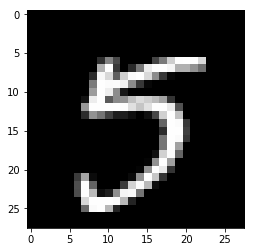

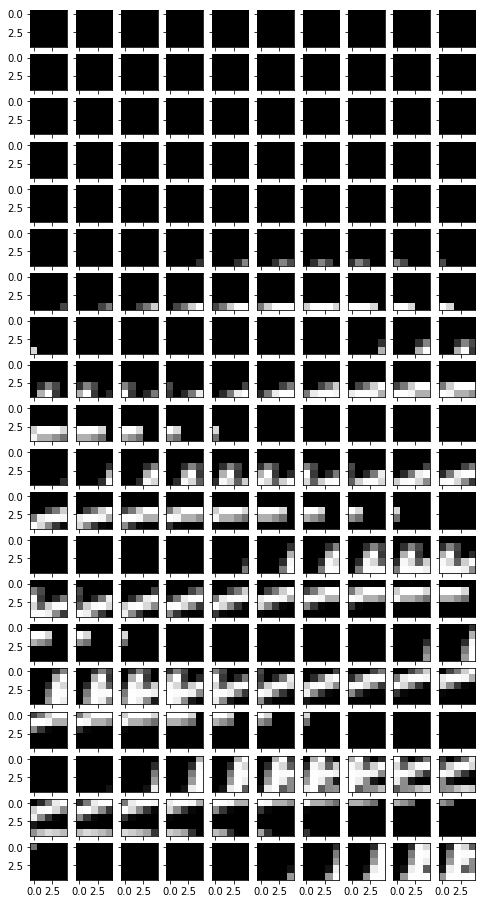

In [161]:
dnet = CRBN((2,28,28),5,(5,5))
print (dnet.D)
dd = torch.cat([data, data], 1)
print (dd.shape)
uf = dnet.unfold(dd)
tuf = uf.transpose(1,2).contiguous().view(-1,dnet.D).detach().cpu()
print (tuf.shape)
print (tuf[0])

plt.imshow(data[0,0].detach().cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()

fig, ax = plt.subplots(20,10, sharex=True, sharey=True, figsize=(8,16))
for i in range(200):
    px = i//10
    py = i%10
    ax[px,py].imshow(tuf[i].view(2,1,5,5)[0,0], cmap='gray', vmin=0, vmax=1)
plt.show()

In [85]:
class BN(nn.Module):
    def __init__(self, size, momentum=0.1):
        super(BN, self).__init__()
        
        self.momentum = momentum
        self.register_buffer('mu',torch.zeros(size))
        self.register_buffer('var', torch.ones(size))
        
    def forward(self, x):
        mu = x.mean(0, keepdim=True)
        self.mu = (1-self.momentum) * self.mu + self.momentum * mu
        var = ((x-self.mu)**2).mean(0, keepdim=True)
        self.var = (1-self.momentum) * self.var + self.momentum * var
        
        return (x-self.mu)/self.var
        


# Deep CRBN
Cause why not?

In [141]:
lr = 2e-3
log = True
L0 = CRBN((1,28,28), 15, (3,3), log=log, lr=lr).eval()
L0.to(device)
B0 = BN((1,15,26,26)).to(device)
# B0 = nn.BatchNorm2d(L0.G, affine=False, track_running_stats=True).to(device)
L1 = CRBN((15,26,26), 20, (3,3), stride=2, log=log, lr=lr).eval()
L1.to(device)
B1 = BN((1,20,12,12)).to(device)
# B1 = nn.BatchNorm2d(L1.G, affine=False, track_running_stats=True).to(device)
L2 = CRBN((20,12,12), 25, (3,3), stride=2, log=log, lr=lr).eval()
L2.to(device)
B2 = BN((1,25,5,5)).to(device)
# B2 = nn.BatchNorm2d(L2.G, affine=False, track_running_stats=True).to(device)
L3 = CRBN((25,5,5), 30, (5,5), log=log, lr=lr).eval()
L3.to(device)
B3 = BN((1,30,1,1)).to(device)
# B3 = nn.BatchNorm2d(L3.G, affine=False, track_running_stats=True).to(device)

LS = [L0, L1, L2, L3]
BNs = [B0, B1, B2, B3]

epochs = 20
rounds = 5

hist = np.zeros((rounds*epochs, len(LS)+1))

layer_learn = 5

for r in range(rounds):
    s = time.time()
    print ("Round: {}/{}".format(r,rounds))

    for e in range(epochs):
        loss = [0 for L in LS]
        for (data, label) in train_loader:
            data = data.to(device)
    #         print (data.shape)
            X = []
            p = data
            for i,L in enumerate(LS):
                # Calculate Forward
                (x,_) = L(p)
                X.append(x)

                # calculate loss
                (pi, sig, mu) = L.params()
                temp = L.unfold(p).view(-1, L.D)
                loss[i] += GMMLoss(temp, pi, sig, mu).item()

                # Learn
                if (layer_learn is None or e//layer_learn == i):
                    L.learn(p)
#                 p = BNs[i](x)
#                 p = x.clamp(-300,300)/300
#                 p = x/500
                p = x/x.max()

        loss.append(sum(loss))
        hist[epochs*r+e] = loss

    #         raise ValueError("STOP")

        print ("Epoch {} : {:.3f}, {:.3f}, {:.3f}, {:.3f} :: {:.3f}".format(*([e]+loss)))
    e = time.time()
    print (e-s)

Epoch 0 : 3538.151, 191488.510, 258658.590, 1543879.805 :: 1997565.056
Epoch 1 : -3434.469, 192188.952, 256480.126, 1527815.540 :: 1973050.149
Epoch 2 : -8302.984, 192019.094, 256230.452, 1535398.638 :: 1975345.201
Epoch 3 : -11602.688, 191355.149, 256480.786, 1541991.578 :: 1978224.825
Epoch 4 : -12508.018, 191408.992, 256301.132, 1540754.432 :: 1975956.538
Epoch 5 : -12590.130, 57325.662, 256247.352, 1546419.524 :: 1847402.407
Epoch 6 : -12590.130, -38330.952, 256570.406, 1549383.786 :: 1755033.110
Epoch 7 : -12590.130, -89160.989, 256848.085, 1555151.697 :: 1710248.663
Epoch 8 : -12590.130, -118580.858, 251844.856, 1552514.804 :: 1673188.672
Epoch 9 : -12590.130, -134380.123, 244750.364, 1572367.263 :: 1670147.374
Epoch 10 : -12590.130, -138903.791, 116202.681, 1577315.357 :: 1542024.117
Epoch 11 : -12590.130, -138902.400, -13310.493, 1578631.950 :: 1413828.927
Epoch 12 : -12590.130, -138906.994, -87375.690, 1571839.737 :: 1332966.922
Epoch 13 : -12590.130, -138906.443, -136835.339,

tensor([5.2227e-01, 9.1819e-02, 9.0897e-02, 8.8959e-02, 7.7978e-02, 5.8624e-02,
        3.7169e-02, 3.2192e-02, 3.2199e-05, 2.0673e-05, 1.8151e-05, 6.1533e-06,
        4.5149e-06, 3.1394e-06, 1.9160e-06])
torch.Size([15, 1, 3, 3])
3 15


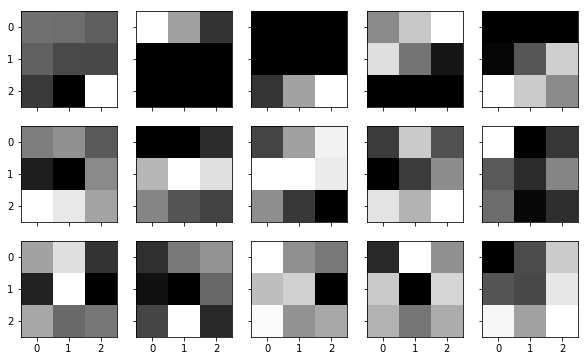

tensor([4.2527e-01, 3.0480e-01, 1.6736e-01, 1.0244e-01, 2.4955e-05, 1.8082e-05,
        1.3557e-05, 1.2908e-05, 9.3155e-06, 8.4181e-06, 6.6084e-06, 5.5455e-06,
        4.9703e-06, 4.7889e-06, 4.5807e-06, 4.1991e-06, 3.5345e-06, 2.4075e-06,
        2.1742e-06, 1.4070e-06])
torch.Size([20, 15, 3, 3])
4 20


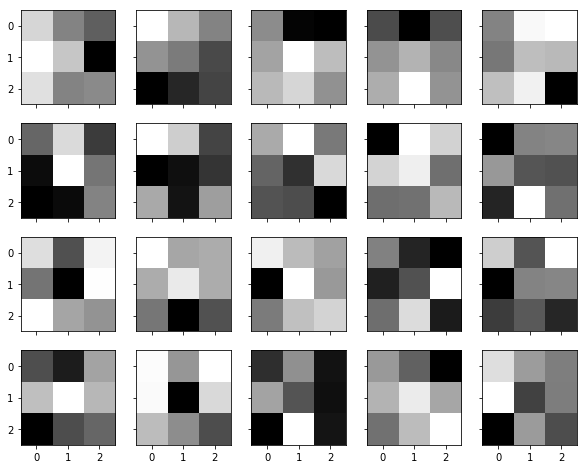

tensor([5.6241e-01, 1.9372e-01, 8.5065e-02, 4.0816e-02, 4.0135e-02, 3.6272e-02,
        1.5832e-02, 1.3289e-02, 1.2222e-02, 6.3481e-05, 3.0848e-05, 2.6177e-05,
        2.0162e-05, 2.0088e-05, 1.9819e-05, 1.4304e-05, 1.4248e-05, 1.0671e-05,
        5.2121e-06, 3.9418e-06, 3.0665e-06, 2.3092e-06, 2.1271e-06, 2.0003e-06,
        1.1520e-06])
torch.Size([25, 20, 3, 3])
5 25


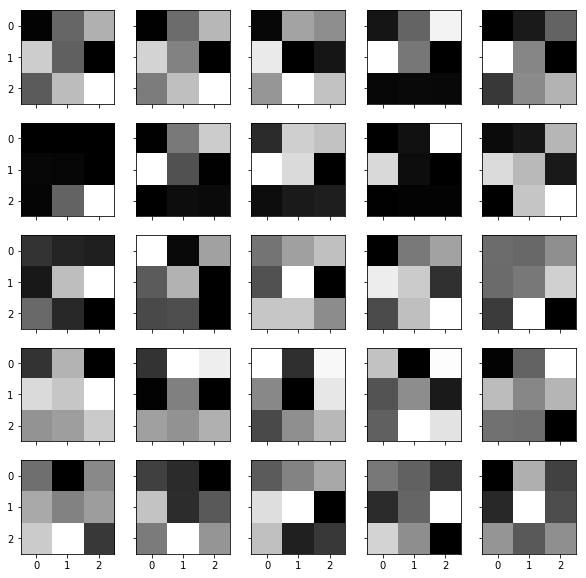

tensor([9.9769e-01, 1.6721e-03, 4.7862e-04, 2.4398e-05, 1.2461e-05, 1.1169e-05,
        1.0698e-05, 9.9102e-06, 9.1820e-06, 9.0906e-06, 8.6608e-06, 8.1729e-06,
        6.8805e-06, 6.1898e-06, 6.1627e-06, 5.1400e-06, 5.1053e-06, 2.6021e-06,
        2.5329e-06, 2.5045e-06, 2.4462e-06, 2.0836e-06, 1.9836e-06, 1.9145e-06,
        1.5803e-06, 1.0687e-06, 1.0535e-06, 1.0511e-06, 7.4080e-07, 6.7246e-07])
torch.Size([30, 25, 5, 5])
6 30


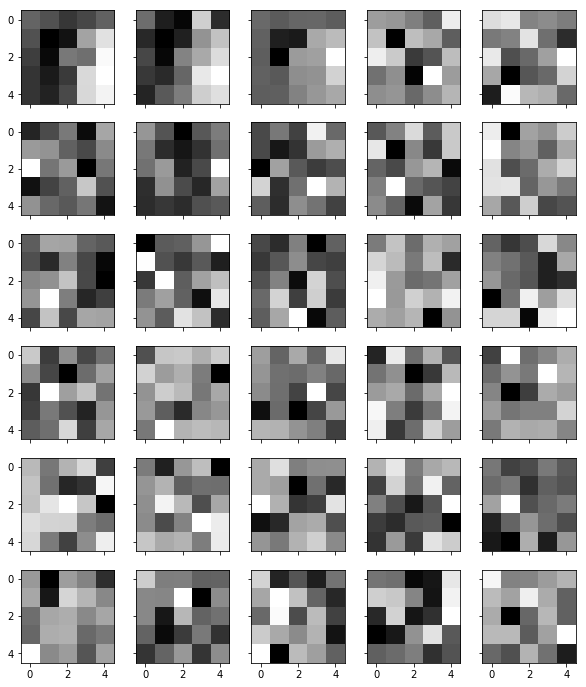

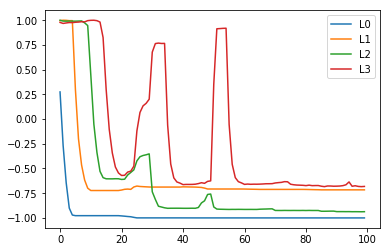

In [142]:

for L in [L0, L1, L2, L3]:
    (pi, sig, mu) = [x.cpu().detach() for x in L.params(True)]
    pi = pi.squeeze()
    vp,pp = pi.sort(descending=True)
    print (vp)

    pmu = mu[pp]
    print (pmu.shape)
    rows = L.G//5
    print (rows, L.G)

    fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
    for i in range(L.G):
        px = i//5
        py = i%5
        ax[px,py].imshow(pmu[i,0], cmap='gray')#, vmin=0, vmax=1)
    plt.show()
    
plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.legend()
plt.show()


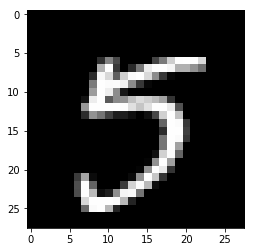

torch.Size([100, 15, 26, 26])


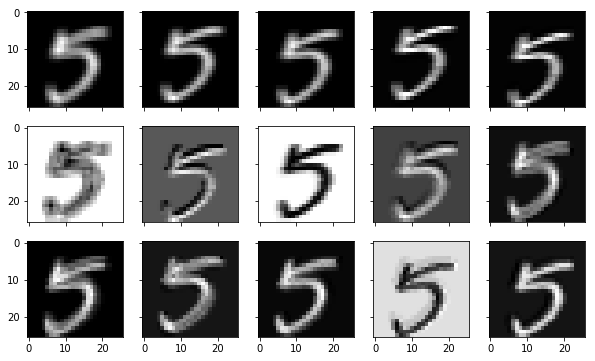

torch.Size([100, 20, 12, 12])


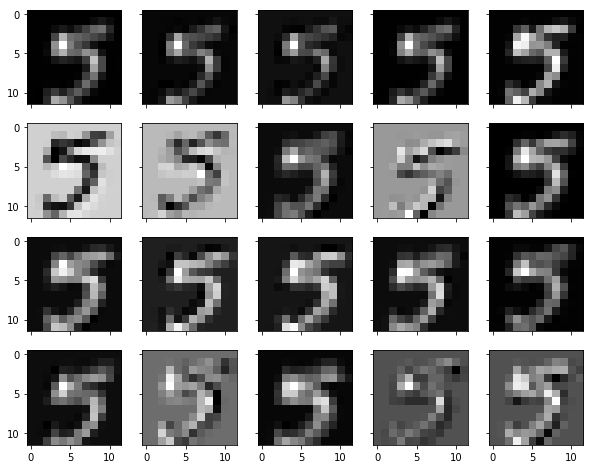

torch.Size([100, 25, 5, 5])


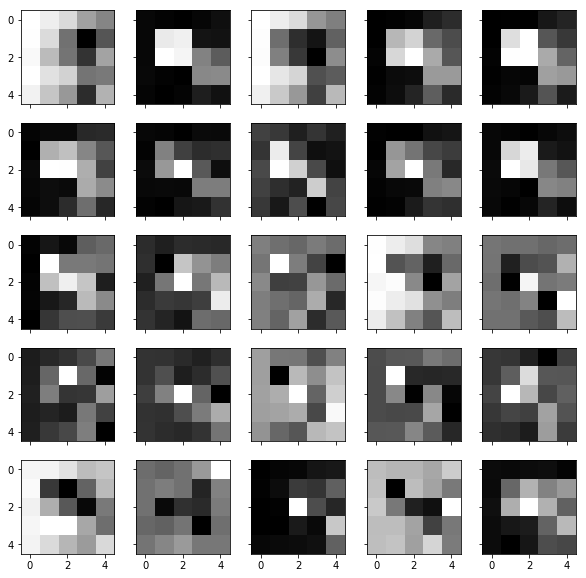

torch.Size([100, 30, 1, 1])


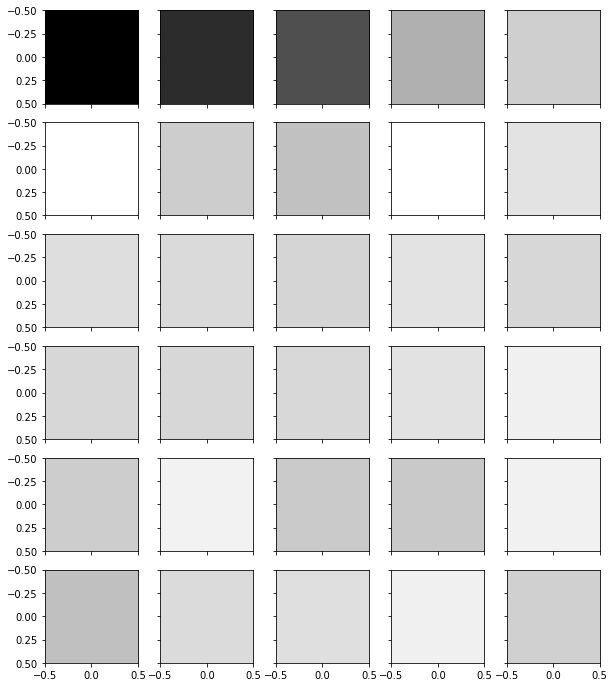

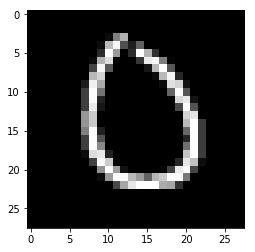

torch.Size([100, 15, 26, 26])


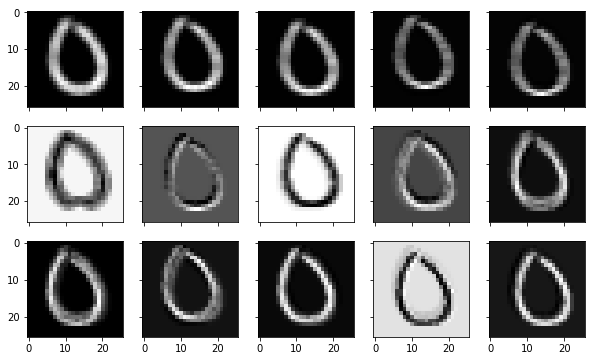

torch.Size([100, 20, 12, 12])


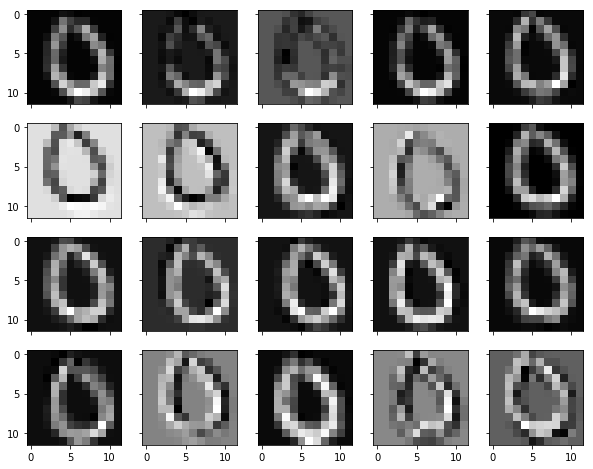

torch.Size([100, 25, 5, 5])


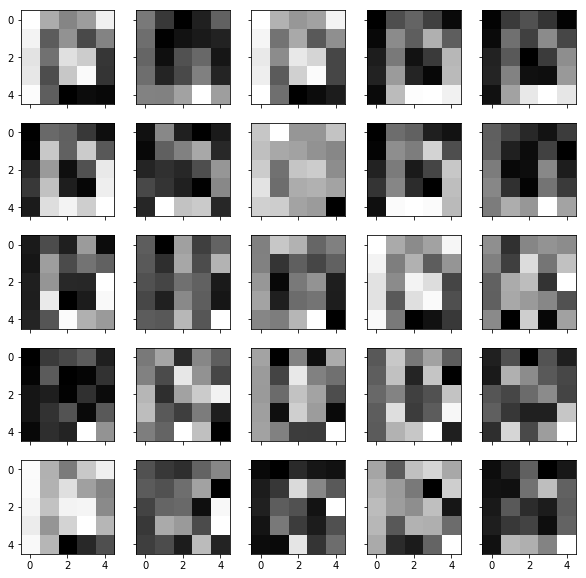

torch.Size([100, 30, 1, 1])


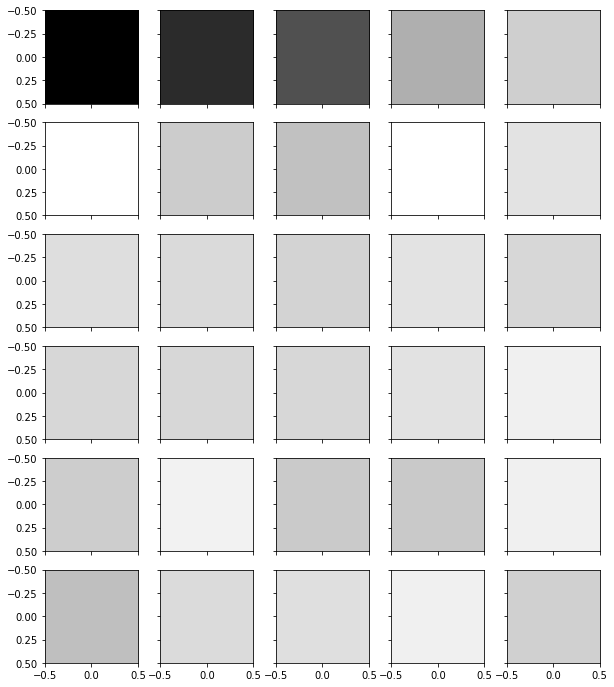

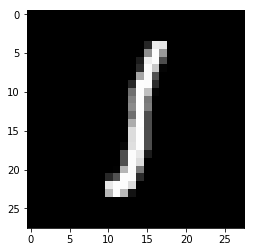

torch.Size([100, 15, 26, 26])


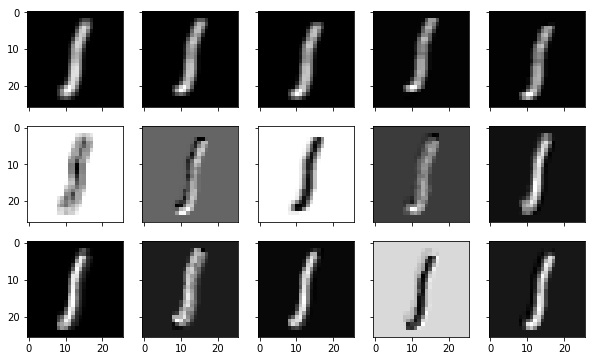

torch.Size([100, 20, 12, 12])


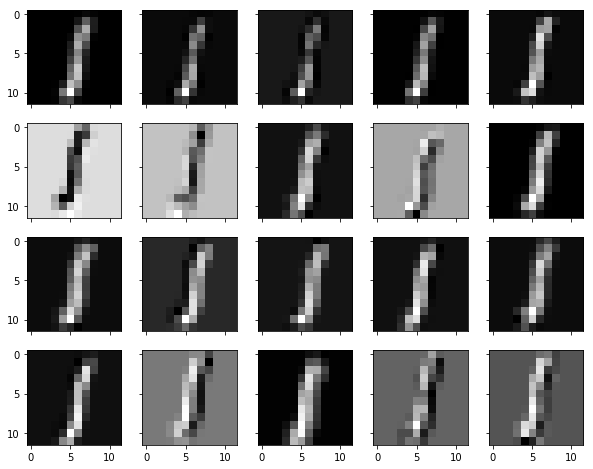

torch.Size([100, 25, 5, 5])


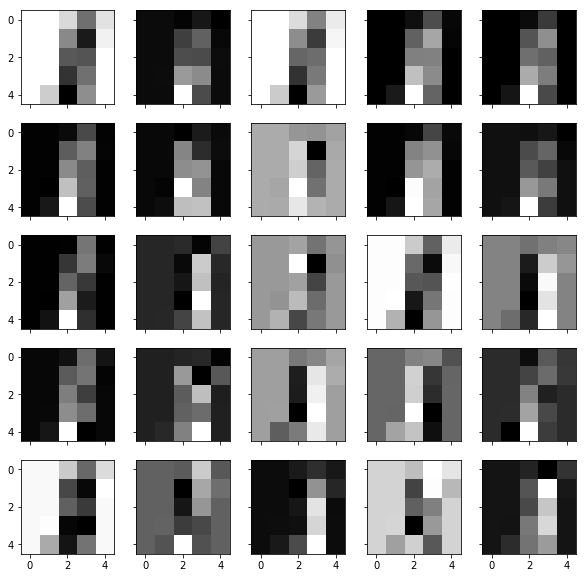

torch.Size([100, 30, 1, 1])


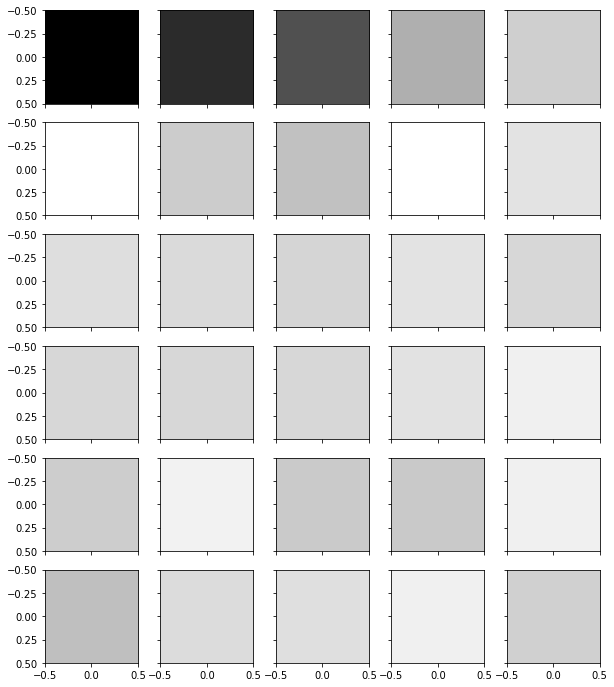

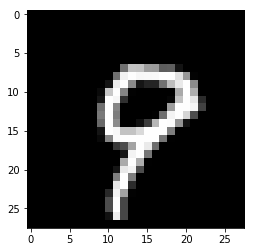

torch.Size([100, 15, 26, 26])


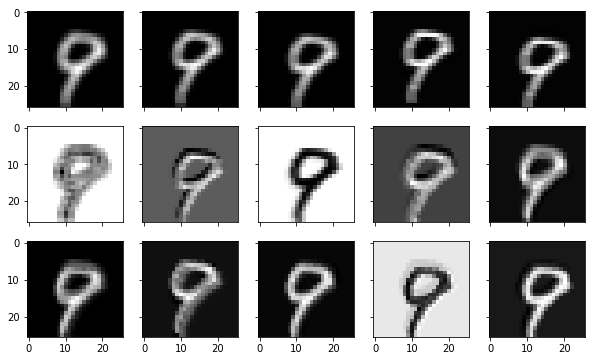

torch.Size([100, 20, 12, 12])


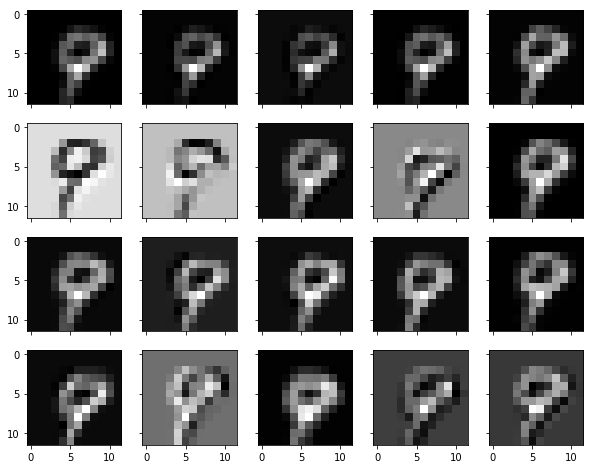

torch.Size([100, 25, 5, 5])


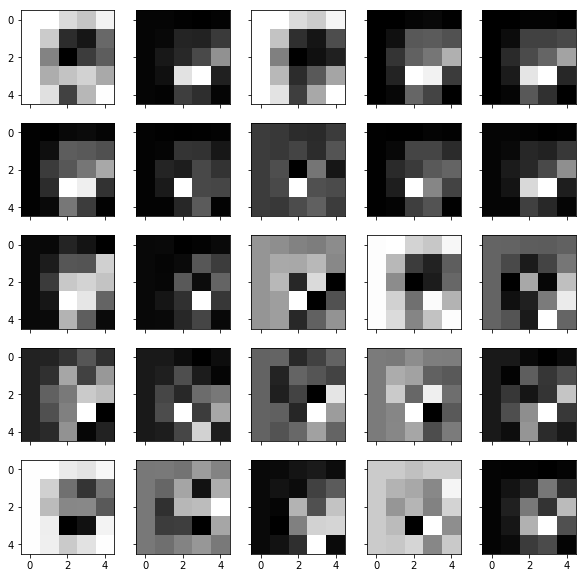

torch.Size([100, 30, 1, 1])


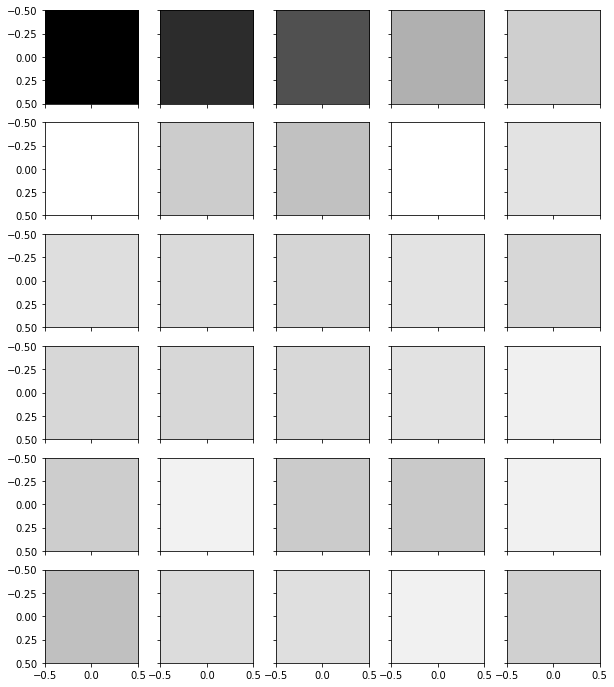

In [143]:
(data, label) = next(iter(train_loader))

for i in range(4):
    dd = data.to(device)

    plt.imshow(data[i,0].cpu().detach(), cmap='gray', vmin=0, vmax=1)
    plt.show()

    for l,L in enumerate([L0, L1, L2, L3]):
        (pi, sig, mu) = [x.cpu().detach() for x in L.params(True)]
        pi = pi.squeeze()
        vp,pp = pi.sort(descending=True)

        rows = L.G//5

        (y,_) = L(dd)
        print (y.shape)
#         dd = y/500
#         dd = y.clamp(-300,300)/300
#         dd = BNs[l](y)
        dd = y/y.max()

        if (l==3):
            vmin = dd[i].min()
            vmax = dd[i].max()
        else:
            vmin = None
            vmax = None

        fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
        for j in range(L.G):
            px = j//5
            py = j%5
            ax[px,py].imshow(dd[i,pp[j]].cpu().detach(), cmap='gray', vmin=vmin, vmax=vmax)
        plt.show()
    
# plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
# plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
# plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
# plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
# plt.legend()
# plt.show()

torch.Size([500, 15, 26, 26])
tensor(-0.0013) tensor(0.2310) tensor(1.7986)
tensor(-0.0036) tensor(0.1054) tensor(0.8135)
tensor(-0.0035) tensor(0.1052) tensor(0.8129)
tensor(-0.0030) tensor(0.0051) tensor(0.0091)
tensor(-0.0060) tensor(0.3406) tensor(0.4137)
tensor(-0.0054) tensor(0.1098) tensor(0.8124)
tensor(0.0033) tensor(0.0113) tensor(0.0564)
tensor(-0.0226) tensor(-0.0155) tensor(0.0042)
tensor(-0.0208) tensor(-0.0148) tensor(0.0054)
tensor(-0.0215) tensor(-0.0139) tensor(0.0164)
tensor(0.0118) tensor(0.0280) tensor(0.0788)
tensor(0.0006) tensor(0.0417) tensor(0.0927)
tensor(-0.0289) tensor(-0.0224) tensor(0.0045)
tensor(0.0099) tensor(0.0213) tensor(0.0698)
tensor(-0.0182) tensor(-0.0098) tensor(0.0231)


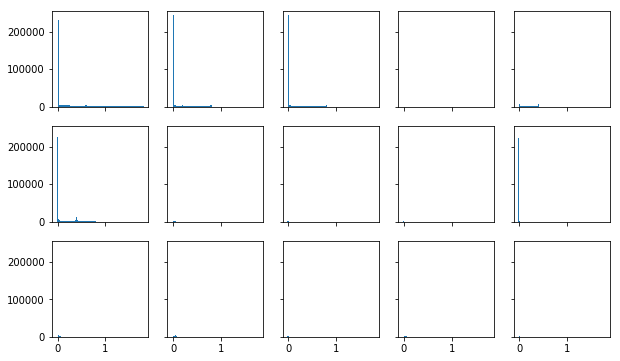

torch.Size([500, 20, 12, 12])
tensor(0.0532) tensor(0.0656) tensor(0.0683)
tensor(1.2954) tensor(1.3156) tensor(1.3191)
tensor(1.9311) tensor(2.2776) tensor(2.3479)
tensor(13.6189) tensor(15.7936) tensor(16.3620)
tensor(16.2521) tensor(19.0595) tensor(19.9153)
tensor(7.3057) tensor(8.9787) tensor(9.7017)
tensor(0.5622) tensor(0.6864) tensor(0.7120)
tensor(0.3431) tensor(0.3876) tensor(0.6493)
tensor(0.4339) tensor(0.4565) tensor(0.4970)
tensor(0.2866) tensor(0.3082) tensor(0.3593)
tensor(0.2991) tensor(0.3254) tensor(0.3347)
tensor(0.2776) tensor(0.2955) tensor(0.3312)
tensor(0.2843) tensor(0.3125) tensor(0.4158)
tensor(0.2660) tensor(0.2840) tensor(0.3126)
tensor(0.1638) tensor(0.2043) tensor(0.2147)
tensor(0.2166) tensor(0.2485) tensor(0.4437)
tensor(0.3841) tensor(0.4068) tensor(0.5013)
tensor(0.3365) tensor(0.3652) tensor(0.4187)
tensor(0.3329) tensor(0.3573) tensor(0.4573)
tensor(0.2444) tensor(0.2515) tensor(0.2776)


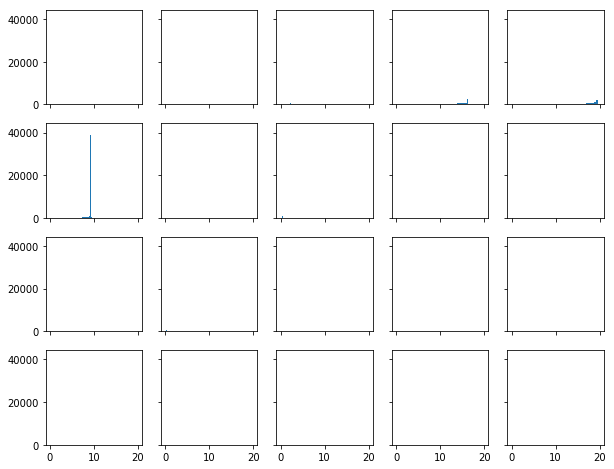

torch.Size([500, 25, 5, 5])
tensor(0.0011) tensor(0.0013) tensor(0.0014)
tensor(3.5495) tensor(4.5833) tensor(4.9301)
tensor(9.0494) tensor(11.6314) tensor(12.4994)
tensor(5.8124) tensor(7.5772) tensor(8.1629)
tensor(9.0065) tensor(11.6911) tensor(12.6569)
tensor(20.0898) tensor(25.7420) tensor(27.5534)
tensor(12.4677) tensor(15.9755) tensor(17.1602)
tensor(6.9570) tensor(9.0343) tensor(9.7558)
tensor(7.5017) tensor(9.7822) tensor(10.5372)
tensor(17.8827) tensor(22.8963) tensor(24.7049)
tensor(16.3731) tensor(21.4353) tensor(23.1943)
tensor(11.6114) tensor(15.0134) tensor(16.1998)
tensor(8.0933) tensor(10.4504) tensor(11.2220)
tensor(14.0695) tensor(18.3148) tensor(19.6619)
tensor(14.1484) tensor(18.3259) tensor(19.8171)
tensor(14.6490) tensor(19.0695) tensor(20.5870)
tensor(11.2886) tensor(14.4849) tensor(15.5319)
tensor(8.3924) tensor(10.8715) tensor(11.6619)
tensor(13.8220) tensor(17.9094) tensor(19.2900)
tensor(12.3197) tensor(15.9280) tensor(17.1695)
tensor(22.3817) tensor(29.0967

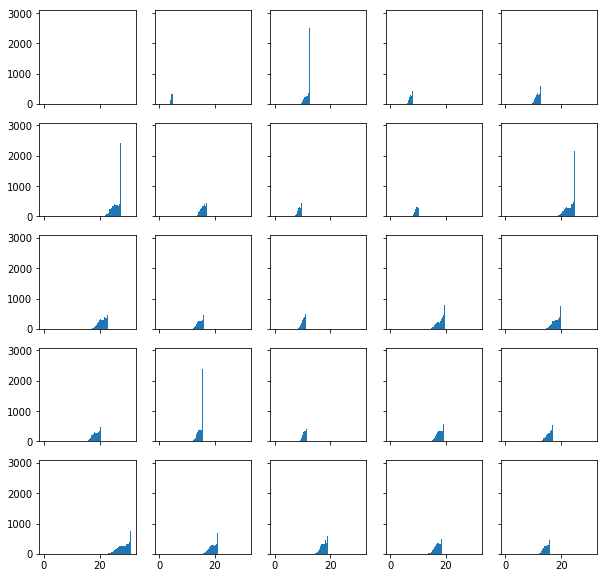

torch.Size([500, 30, 1, 1])
tensor(nan) tensor(nan) tensor(nan)


/opt/anaconda/envs/tbj/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6575: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda/envs/tbj/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6576: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: max must be larger than min in range parameter.

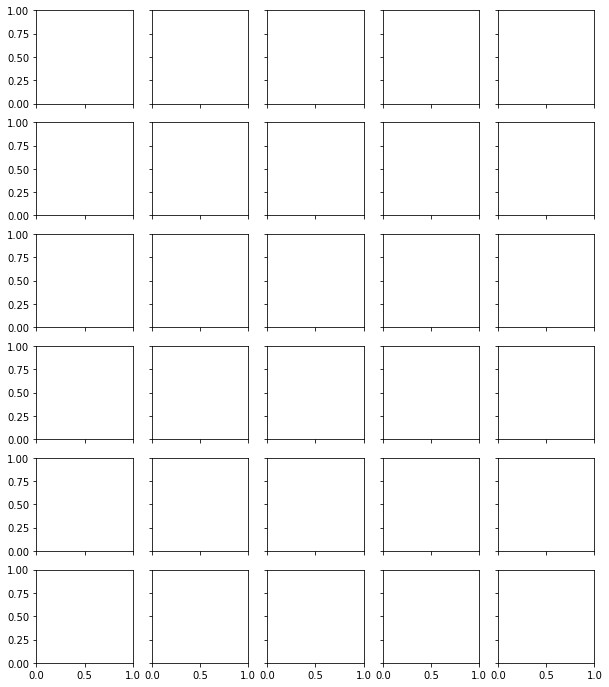

In [139]:
(data, label) = next(iter(big_batch))

dd = data.to(device)


for l,L in enumerate([L0, L1, L2, L3]):
    (pi, sig, mu) = [x.cpu().detach() for x in L.params(True)]
    pi = pi.squeeze()
    vp,pp = pi.sort(descending=True)

    rows = L.G//5

    (y,_) = L(dd)
    print (y.shape)
    dd = y.detach()/y.max()
    y = y.cpu().detach()/y.max()#.clamp(-300,300)/300
#     dd = BNs[l](y)
#     y = BNs[l](y).detach().cpu()

    if (l==3):
        vmin = dd[i].min()
        vmax = dd[i].max()
    else:
        vmin = None
        vmax = None

    fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
    for j in range(L.G):
        px = j//5
        py = j%5
        print (y[:,pp[j]].min(),y[:,pp[j]].mean(),y[:,pp[j]].max())
        ax[px,py].hist(y[:,pp[j]].flatten(), bins=50)
    plt.show()


# Fixing things

I think I know what is wrong.... there are potentially two problems

Consider that with a diagonal $\Sigma$ the final probability is really a product of the guassian probabilities in each direction, that means that a single wrong position could tank the total probability. Of course this is partially accounted for with the $\Sigma$ which leads to the larger more severe problem

The log probability contains a term of the form $\ln(\frac{1}{|\Sigma|})$ this is very punishing for modes which allow for large variances in certain inputs (i.e unimportant inputs. When considering the mixture model modes with large variances are going to be practically $-\infty$ which means a lot of modes might just be dropped out of later representations.

## Solution
we tried clamping but this doesn't fully solve the problem because it ignore which piece is causing the large negative value. Potential solution 1 is to clamp the individual badness when working with each component of the log probability. I.e clamp the log probability values so there is a maximum impact it may have. This is tricky because the clamping becomes a hyper parameter but doable

Option 2 is to not use the correct formula for log prob and use a modified one that skips the $\ln(\frac{1}{|\Sigma|})$ term for forward passing ONLY. Note that for learning we still need the sigma term because it incentivizes sigma to not get infinitely big which happens otherwise.

I'm going to implement the second option first as a new way to calculate the forward component

# Notes:

The $\ln(\frac{1}{|\Sigma|})$ term can be thought of as a regularization term on $\Sigma$ we could potentially use other regularizers in order to promote the good behaviour.

The "gain" on mixture components can be straight added to the component terms. this corresponds to a multiplcation of the probabilities.

In [157]:
def MixtureLogProb(x, pi, sig, mu):
    if (len(x.shape)==2):
        x = x.unsqueeze(1)
        
    print (x.shape)
    print (pi.shape)
    print (sig.shape)
    print (mu.shape)
        
    mal_dist = ((x-mu)**2/sig).sum(-1)
    print (mal_dist.shape)
    log_prob = torch.log(pi) + mal_dist
    print (log_prob.shape)
    
    return log_prob

D = 5
G = 10
BS= 20

x = torch.zeros((BS,D))
R = RBN(D, G)

(pi, sig, mu) = R.params()

print (pi.shape)
print (sig.shape)
print (mu.shape)
print (x.shape)
print ("----------")
LP = MixtureLogProb(x, pi, sig, mu)
print (LP[0])
OP = GMMProbs(x, pi, sig, mu, log=True)
print (OP[0])

torch.Size([1, 10])
torch.Size([1, 10, 5])
torch.Size([1, 10, 5])
torch.Size([20, 5])
----------
torch.Size([20, 1, 5])
torch.Size([1, 10])
torch.Size([1, 10, 5])
torch.Size([1, 10, 5])
torch.Size([20, 10])
torch.Size([20, 10])
tensor([ 3.7206,  5.9613,  1.3441,  2.0092,  0.7401,  0.6455,  5.1180,  3.9128,
         3.5465, -0.9074], grad_fn=<SelectBackward>)
tensor([-11.2109, -12.3062, -11.2085, -11.6944,  -9.0755, -10.3522, -20.7864,
        -19.6252, -13.0053, -11.6704], grad_fn=<SelectBackward>)
